In [ ]:
# =============================================================================
# 1. CONFIGURACIÓN E IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os, random
import joblib
from tqdm import tqdm

# Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# TensorFlow / Keras (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Modelos de Panel
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Configuración Global
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# =============================================================================
# 2. CARGA DE DATOS Y PREPARACIÓN
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
try:
    df_raw = pd.read_csv(url)
    print("Datos cargados desde URL.")
except:
    # Fallback local
    df_raw = pd.read_csv("Data_final.csv")
    print("Datos cargados localmente.")

df_raw['ds'] = pd.to_datetime(df_raw['year'], format='%Y')
df_raw = df_raw.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
df_raw[TARGET] = np.log1p(df_raw[TARGET])

# Features Base (Sin Lags)
features_base = [
    'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 
    'pib_per_capita', 'inscripcion_primaria', 
    'inscripcion_secundaria', # <--- AGREGADA
    'inscripcion_terciaria',
    'areas_protegidas',       # <--- AGREGADA 
    'gasto_educacion_pib', 'investigadores_RD', 'art_cientificos',
    'gbif_member', 'ogp_membership'
]

# =============================================================================
# 3. DIAGNÓSTICO DE VARIABLES (FE & LASSO)
# =============================================================================
def run_diagnostics(df, features):
    print("\n--- 1. DIAGNÓSTICO DE VARIABLES ---")
    df_panel = df.set_index(['country', 'year'])
    df_clean = df_panel[features + [TARGET]].dropna()
    
    exog = sm.add_constant(df_clean[features])
    mod_fe = PanelOLS(df_clean[TARGET], exog, entity_effects=True)
    res_fe = mod_fe.fit(cov_type='clustered', cluster_entity=True)
    
    print(">>> Variables Significativas (FE p<0.10):")
    print(res_fe.params[res_fe.pvalues < 0.1])
    return res_fe

_ = run_diagnostics(df_raw, features_base)

2025-11-17 13:00:37.112072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Datos cargados desde URL.

--- 1. DIAGNÓSTICO DE VARIABLES ---
>>> Variables Significativas (FE p<0.10):
uso_internet           0.163655
gasto_educacion_pib    0.424224
investigadores_RD      0.000566
gbif_member            5.093305
Name: parameter, dtype: float64


In [ ]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS (TABULAR Y SECUENCIAL) - CORREGIDO
# =============================================================================

# Función de Ingeniería Temporal
def create_temporal_features(df, features_input, lags=[1, 3], roll_win=[3]):
    df_out = df.copy()
    # Aseguramos que las variables a transformar sean numéricas
    vars_to_transform = features_input + [TARGET]
    
    for col in vars_to_transform:
        if col not in df_out.columns: continue # Seguridad
        
        for l in lags:
            df_out[f'{col}_lag{l}'] = df_out.groupby('country')[col].shift(l)
        for w in roll_win:
            df_out[f'{col}_roll_mean{w}'] = df_out.groupby('country')[col].shift(1).rolling(w).mean()
    return df_out

# Generar DataFrame Maestro
df_ml = create_temporal_features(df_raw, features_base)
df_ml = df_ml.dropna().reset_index(drop=True)

# Seleccionamos explícitamente solo columnas NUMÉRICAS
# y excluimos columnas que no son predictoras (ids, años, target)
cols_exclude = ['year', 'ds', TARGET, 'country', 'countryCode', 'iso2', 'code'] # Lista negra ampliada
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
features_tabular = [c for c in numeric_cols if c not in cols_exclude]

print(f"✅ Features seleccionadas ({len(features_tabular)}):")
print(features_tabular)

# Preparar Datos Tabulares (X, y)
X_tab = df_ml[features_tabular]
y_tab = df_ml[TARGET]

# Preparar Datos Secuenciales (LSTM) - GLOBAL
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    
    # Validar que features existen y son numéricas
    valid_features = [f for f in features if f in df.columns and pd.api.types.is_numeric_dtype(df[f])]
    
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        
        if len(df_country) == 0: continue
            
        X_country = df_country[valid_features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(df_raw, features_base, TARGET, look_back)

print(f"Datos listos. Features Tabulares: {len(features_tabular)}. Secuencias LSTM: {len(X_seq)}")

✅ Features seleccionadas (54):
['superficie_total_km2', 'areas_protegidas', 'gasto_RD_pib', 'efectividad_gobierno', 'art_cientificos', 'uso_internet', 'pib_per_capita', 'inscripcion_primaria', 'inscripcion_secundaria', 'inscripcion_terciaria', 'gasto_educacion_gobierno', 'gasto_educacion_pib', 'investigadores_RD', 'Overall score', 'region', 'incomeLevel', 'gbif_member', 'ogp_membership', 'gasto_RD_pib_lag1', 'gasto_RD_pib_lag3', 'gasto_RD_pib_roll_mean3', 'efectividad_gobierno_lag1', 'efectividad_gobierno_lag3', 'efectividad_gobierno_roll_mean3', 'uso_internet_lag1', 'uso_internet_lag3', 'uso_internet_roll_mean3', 'pib_per_capita_lag1', 'pib_per_capita_lag3', 'pib_per_capita_roll_mean3', 'inscripcion_primaria_lag1', 'inscripcion_primaria_lag3', 'inscripcion_primaria_roll_mean3', 'inscripcion_terciaria_lag1', 'inscripcion_terciaria_lag3', 'inscripcion_terciaria_roll_mean3', 'gasto_educacion_pib_lag1', 'gasto_educacion_pib_lag3', 'gasto_educacion_pib_roll_mean3', 'investigadores_RD_lag1'

In [7]:
# =============================================================================
# 5. HIPERPARÁMETROS Y OPTIMIZACIÓN (TU CÓDIGO ORIGINAL MEJORADO)
# =============================================================================

# RF
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt']
}

# XGBoost
xgb_param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "gamma": [0, 0.1],
    "reg_alpha": [0, 0.01]
}

# LSTM
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "lr": 0.005, "activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.001, "activation": "tanh"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "lr": 0.005, "activation": "tanh"}
]

# Funciones de Optimización
def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=SEED)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_xgboost(X_train, y_train, param_dist=xgb_param_dist):
    # XGBoost con RandomizedSearchCV
    xgb_model = xgb.XGBRegressor(random_state=SEED, n_jobs=-1, objective='reg:squarederror')
    search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=SEED)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    best_params = {}
    
    # Split interno para validación (Early Stopping)
    # Importante: Shuffle=False para mantener orden temporal si fuera serie única, 
    # pero aquí son secuencias mezcladas de panel. Shuffle=True es aceptable para validación interna de epochs.
    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED, shuffle=False)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)
    
    for params in param_grid:
        model = Sequential([
            LSTM(params["units"], activation=params["activation"], input_shape=(look_back, X_train.shape[2])),
            Dropout(params["dropout"]),
            Dense(1)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_t, y_t, epochs=params["epochs"], batch_size=params["batch_size"], 
                  validation_data=(X_v, y_v), callbacks=[es], verbose=0)
        
        preds = model.predict(X_v, verbose=0).flatten()
        mae = mean_absolute_error(y_v, preds)
        
        if mae < best_mae:
            best_mae, best_model = mae, model
            best_params = params
            
    return best_model, best_params

In [8]:
# =============================================================================
# 6. MÉTRICAS Y EVALUACIÓN
# =============================================================================
def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true_log, y_pred_log):
    # Revertir Log1p para métricas interpretables
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred)
    }

# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (TU CÓDIGO INTEGRADO)
# =============================================================================
print("\n--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---")

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
results_detailed = {"RandomForest": [], "XGBoost": [], "LSTM": []}

# Bucle principal
for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")
    
    # --- A. PREPROCESAMIENTO (Imputación y Escalado DENTRO del fold) ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]
    
    # 1. Imputación
    imputer = IterativeImputer(random_state=SEED, estimator=RandomForestRegressor(random_state=SEED))
    X_train_imp = imputer.fit_transform(X_train_tab)
    X_test_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado Tabular
    scaler_tab = StandardScaler()
    X_train_sc = scaler_tab.fit_transform(X_train_imp)
    X_test_sc = scaler_tab.transform(X_test_imp)
    
    # --- B. MODELOS TABULARES ---
    
    # RandomForest
    try:
        rf_model, rf_params = optimize_random_forest(X_train_sc, y_train_tab)
        y_pred_rf = rf_model.predict(X_test_sc)
        metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
        results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})
    except Exception as e:
        print(f"RF Error: {e}")

    # XGBoost
    try:
        xgb_model, xgb_params = optimize_xgboost(X_train_sc, y_train_tab)
        y_pred_xgb = xgb_model.predict(X_test_sc)
        metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
        results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})
    except Exception as e:
        print(f"XGB Error: {e}")
        
    # --- C. LSTM ---
    # Filtrar años correspondientes al fold actual para seleccionar secuencias
    train_years_fold = df_ml.iloc[train_idx]['year'].unique()
    test_years_fold = df_ml.iloc[test_idx]['year'].unique()
    
    mask_train = np.isin(years_seq, train_years_fold)
    mask_test = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train], y_seq[mask_train]
    X_test_lstm, y_test_lstm = X_seq[mask_test], y_seq[mask_test]
    
    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        try:
            # Escalado LSTM (3D -> 2D -> 3D)
            scaler_lstm_X = StandardScaler()
            X_train_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
            scaler_lstm_X.fit(X_train_flat)
            
            X_train_lstm_sc = scaler_lstm_X.transform(X_train_flat).reshape(X_train_lstm.shape)
            X_test_lstm_sc = scaler_lstm_X.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[2])).reshape(X_test_lstm.shape)
            
            # Escalado Target LSTM
            scaler_lstm_y = StandardScaler()
            y_train_lstm_sc = scaler_lstm_y.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
            
            # Optimización y Predicción
            lstm_model, lstm_params = optimize_lstm(X_train_lstm_sc, y_train_lstm_sc, look_back)
            
            y_pred_lstm_sc = lstm_model.predict(X_test_lstm_sc, verbose=0).flatten()
            y_pred_lstm = scaler_lstm_y.inverse_transform(y_pred_lstm_sc.reshape(-1, 1)).flatten()
            
            # Métricas
            metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
            results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})
        except Exception as e:
            print(f"LSTM Error: {e}")

# --- RESUMEN DE RESULTADOS ---
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    print("\nResultados Detallados:")
    print(df_results.drop(columns=['hyperparameters']).head(10)) # Ocultar params para ver tabla limpia
    
    print("\n" + "="*50)
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print("RESUMEN PROMEDIO POR MODELO:")
    print(summary)
    print("="*50)
    
    best_model_name = summary.index[0]
    print(f"\n🏆 MEJOR MODELO SELECCIONADO: {best_model_name}")


--- 2. INICIANDO VALIDACIÓN CRUZADA (TimeSeriesSplit) ---


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====
XGB Error: 'super' object has no attribute '__sklearn_tags__'


2025-11-17 13:04:56.380423: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-17 13:04:56.381983: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-17 13:04:56.382056: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-17 13:04:56.382648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-17 13:04:56.383133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-17 13:04:57.963970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:04:58.145797:


===== FOLD 2/5 =====
XGB Error: 'super' object has no attribute '__sklearn_tags__'


2025-11-17 13:05:33.253556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:05:33.412075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-17 13:05:35.289551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:05:40.582124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:05:40.944263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 3/5 =====
XGB Error: 'super' object has no attribute '__sklearn_tags__'


2025-11-17 13:06:13.145192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:06:13.304711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-17 13:06:15.203990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:06:27.400986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:06:27.760719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====
XGB Error: 'super' object has no attribute '__sklearn_tags__'


2025-11-17 13:07:06.048824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:07:06.214753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-17 13:07:08.081300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:07:13.410872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:07:13.782780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====
XGB Error: 'super' object has no attribute '__sklearn_tags__'


2025-11-17 13:07:59.106662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:07:59.277479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-17 13:08:01.328087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:08:14.136375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-17 13:08:14.520443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


Resultados Detallados:
          model           MAE          RMSE        R2          MAPE  \
0  RandomForest  3.978589e+06  7.257274e+06  0.632177  1.249038e+14   
1  RandomForest  4.209368e+06  1.017832e+07  0.881038  8.620427e+01   
2  RandomForest  2.171011e+06  4.326993e+06  0.957626  5.588474e+01   
3  RandomForest  1.198314e+06  2.084580e+06  0.971867  1.201844e+11   
4  RandomForest  5.731380e+07  1.596048e+08  0.138001  2.221780e+11   
5          LSTM  1.736480e+07  4.844794e+07  0.616628  9.672920e+13   
6          LSTM  1.185294e+07  2.994880e+07  0.853503  1.920988e+14   
7          LSTM  1.801918e+07  6.190351e+07  0.374108  1.244374e+14   
8          LSTM  3.196047e+07  1.541700e+08 -2.882119  6.406970e+13   
9          LSTM  1.315520e+07  3.717046e+07  0.774335  1.453886e+14   

        SMAPE  fold  
0   68.848286     1  
1   46.103267     2  
2   35.077792     3  
3   36.154657     4  
4   68.434837     5  
5  105.343652     1  
6   79.360390     2  
7   95.626670     


--- 3. GENERANDO ESCENARIOS FUTUROS (RandomForest) ---


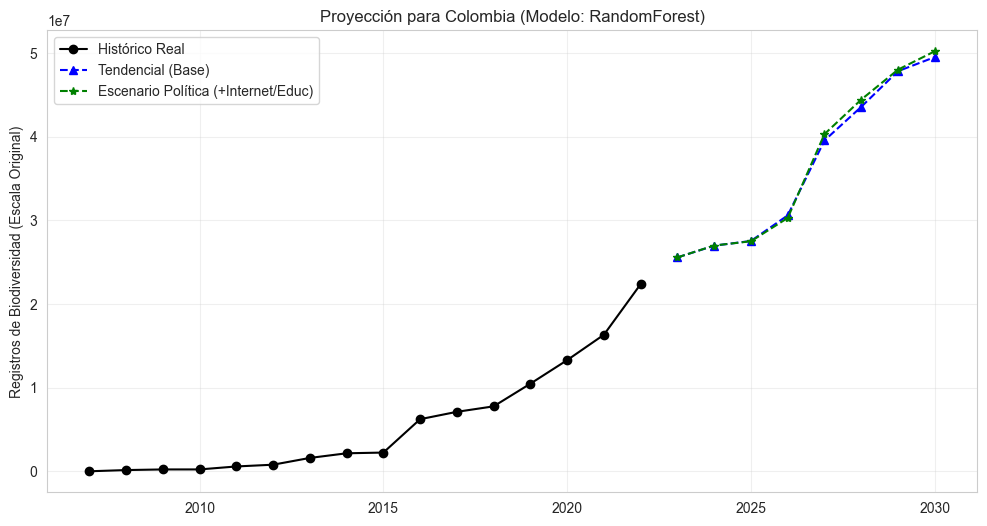


RESULTADO 2030 (Colombia):
Base Tendencial: 49,507,672 registros
Con Política:    50,206,644 registros
Diferencia Neta: +698,972 registros


In [9]:
# =============================================================================
# 8. RE-ENTRENAMIENTO FINAL Y SIMULACIÓN
# =============================================================================
print(f"\n--- 3. GENERANDO ESCENARIOS FUTUROS ({best_model_name}) ---")

# Preparamos TODOS los datos para el entrenamiento final
imputer_final = IterativeImputer(random_state=SEED)
X_final_imp = imputer_final.fit_transform(X_tab)
scaler_final = StandardScaler()
X_final_sc = scaler_final.fit_transform(X_final_imp)
y_final = y_tab

# Entrenar modelo ganador final
if best_model_name == 'RandomForest':
    # Para la versión final, usamos parámetros optimizados de la última vuelta o re-buscamos
    final_model, _ = optimize_random_forest(X_final_sc, y_final)
elif best_model_name == 'XGBoost':
    final_model, _ = optimize_xgboost(X_final_sc, y_final)
else:
    # Si gana LSTM, habría que re-entrenarlo con la lógica secuencial completa
    # Simplificación: Usar RF como fallback si LSTM gana pero es complejo de implementar en recursivo
    print("Aviso: Usando RF para proyección por simplicidad de implementación.")
    final_model, _ = optimize_random_forest(X_final_sc, y_final)

# --- MOTOR DE SIMULACIÓN RECURSIVA ---
def recursive_simulation(model, df_raw, country, start_yr, end_yr, scenario_params):
    # 1. Copia histórica
    df_sim = df_raw[df_raw['country'] == country].copy()
    last_year_hist = df_sim['year'].max()
    
    # 2. Proyectar Exógenas
    future_years = list(range(start_yr, end_yr + 1))
    rows_future = []
    
    # Dataframe temporal para calcular tendencias
    df_trend = df_sim.sort_values('year')
    
    for yr in future_years:
        row = {'country': country, 'year': yr}
        for col in features_base:
            # Tendencia lineal simple de los últimos 5 años
            vals = df_trend[col].dropna().tail(5).values
            if len(vals) > 1:
                z = np.polyfit(range(len(vals)), vals, 1)
                val = np.poly1d(z)(len(vals) + (yr - last_year_hist) - 1)
            else:
                val = vals[-1] if len(vals) > 0 else 0
            
            # Escenarios
            if col in scenario_params:
                val *= scenario_params[col]
            
            # Clips lógicos
            if 'uso_internet' in col: val = np.clip(val, 0, 100)
            
            row[col] = val
        rows_future.append(row)
        df_trend = pd.concat([df_trend, pd.DataFrame([row])], ignore_index=True)
        
    df_future = pd.DataFrame(rows_future)
    df_future[TARGET] = 0 # Placeholder
    
    # 3. Unión y Predicción Recursiva
    df_sim = pd.concat([df_sim, df_future], ignore_index=True).reset_index(drop=True)
    
    for yr in future_years:
        # Recalcular features dinámicas (Lags/Rolling)
        df_dyn = create_temporal_features(df_sim, features_base)
        
        # Obtener vector del año actual
        idx = df_dyn[df_dyn['year'] == yr].index[0]
        X_curr = df_dyn.loc[[idx], features_tabular]
        
        # Aplicar transformaciones guardadas (Imputer -> Scaler)
        X_curr_imp = imputer_final.transform(X_curr)
        X_curr_sc = scaler_final.transform(X_curr_imp)
        
        # Predecir
        pred_log = model.predict(X_curr_sc)[0]
        df_sim.loc[idx, TARGET] = pred_log
        
    return df_sim

# --- EJECUCIÓN ---
target_country = 'Colombia'
start_proj = 2023
end_proj = 2030

# Escenario Base
df_base = recursive_simulation(final_model, df_raw, target_country, start_proj, end_proj, {})

# Escenario Política (+15% Internet, +10% Educación)
scen_pol = {'uso_internet': 1.15, 'gasto_educacion_pib': 1.10}
df_pol = recursive_simulation(final_model, df_raw, target_country, start_proj, end_proj, scen_pol)

# Visualización
plt.figure(figsize=(12, 6))
hist = df_raw[df_raw['country'] == target_country]
plt.plot(hist['year'], np.expm1(hist[TARGET]), 'k-o', label='Histórico Real')
plt.plot(df_base[df_base['year'] >= start_proj]['year'], np.expm1(df_base[df_base['year'] >= start_proj][TARGET]), 'b--^', label='Tendencial (Base)')
plt.plot(df_pol[df_pol['year'] >= start_proj]['year'], np.expm1(df_pol[df_pol['year'] >= start_proj][TARGET]), 'g--*', label='Escenario Política (+Internet/Educ)')

plt.title(f"Proyección para {target_country} (Modelo: {best_model_name})")
plt.ylabel("Registros de Biodiversidad (Escala Original)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Conclusión Numérica
val_base = np.expm1(df_base.iloc[-1][TARGET])
val_pol = np.expm1(df_pol.iloc[-1][TARGET])
print(f"\nRESULTADO 2030 ({target_country}):")
print(f"Base Tendencial: {val_base:,.0f} registros")
print(f"Con Política:    {val_pol:,.0f} registros")
print(f"Diferencia Neta: +{val_pol - val_base:,.0f} registros")